## CNN Evaluation
#### In this notebook the trained CNN models are evaluated densely on the Test high power fields

In [ ]:
#Version checking
import sys
import keras
print(sys.version)
print(sys.version_info)
print(keras.__version__)

In [37]:
import time
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from matplotlib.pyplot import imread
import random
from sklearn.metrics.pairwise import manhattan_distances

from os.path import join, basename, dirname, exists  
import os  
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.insert(0, 'utils')
import utils_patches
import config
import importlib

sys.path.insert(0,'models_code')
from models_code import models_keras

importlib.reload(utils_patches)#Debugging purposes, not recomended in final version of the code!
from utils_patches import localize_mitosis, localize_mitosis_patches, extract_patches, load_image, plot_image
from utils_patches import simplePatchGenerator, compute_probs_sliding_window_v2, compute_probs_sliding_window_v1
#import utils_patches import *
import configparser


Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/
(32, 63, 63, 3)
(32, 2)


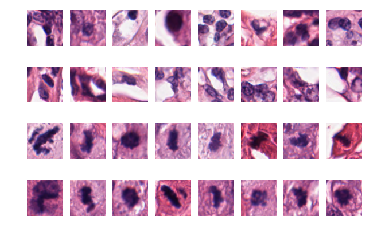

In [3]:

# Test the data generator
training_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/', 
    batch_size=32,
    img_shape = (63,63,3)
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8) 
    break

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/
(32, 63, 63, 3)
(32, 2)


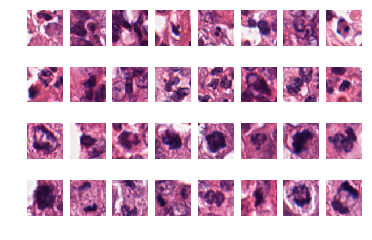

In [4]:
val_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/', 
    batch_size=32,
    img_shape = (63,63,3)
)
for batch_x, batch_y in val_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break
#batch_y

In [23]:
from keras.models import Sequential


In [5]:
#Defining the CallBacks for tensorboard visualization and for earlystopping of the model
exp_name = 'baseline_lafrange'
checkpointer = ModelCheckpoint(filepath='/home/sebastian/local_experiments/staining/models/lafrange_model/'+exp_name+'decay_skL_softmax_ADAM_weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='/home/sebastian/local_experiments/staining/logs'+exp_name+'/', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [7]:
batch_size = 64
lambda_m = 0.1
epoch_size = 4000
Tp_min, Fp_max = 400, 100
model_mitosis = models_keras.mitosis_model(lambda_m,True)


In [8]:
max_epochs = 10
trainPhase = False
if trainPhase:    
    model_mitosis.fit_generator(training_gen, epochs=max_epochs,verbose=1,callbacks=[checkpointer,tb_callback], validation_data=val_gen, validation_steps=20,steps_per_epoch=2000)

In [9]:
#Loading best model to check performance on test dataset
path_model_weights ='/home/sebastian/local_experiments/staining/models/lafrange_model/baseline_lafrangedecay_skL_softmax_ADAM_weights.10-0.50.hdf5'
model_mitosis.load_weights(path_model_weights)

In [10]:
#The path should be changed according to the ppartition being processed, i.e., training/val/test
path_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/mitosis/'
list_test_imgs = glob.glob(path_test_images + '**.png')
test_batches_paths = [list_test_imgs[i:i+64] for i in range(0,len(list_test_imgs),64)]

path_neg_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/non_mitosis/'
list_neg_test_imgs = glob.glob(path_neg_test_images + '**.png')
test_neg_batches_paths = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
print(len(list_test_imgs),len(list_neg_test_imgs))

533 12317


In [11]:
def evaluate_threshold_validation(model,validation_images_path,perf_meassure='f1'):
    list_val_imgs = glob.glob(validation_images_path + 'mitosis/' +  '**.png')
    val_batches_paths = [list_val_imgs[i:i+64] for i in range(0,len(list_val_imgs),64)]
    list_neg_test_imgs = glob.glob(validation_images_path + 'non_mitosis/' +'**.png')
    val_neg_batches_paths  = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
    
    #Computing probabilities for mitotic patches
    probabilites = []
    for batch in val_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_probs = np.array([j for i in probabilites for j in i])
    
    #Computing probabilities for non mitotic patches
    neg_probabilites = []
    for batch in val_neg_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
    gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
    all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
    fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
    roc_auc = auc(fpr,tpr)
    max_f1 = 0
    best_thres = 0
    for cur_thres in thresholds:
        cur_f1 = f1_score(gt_labels, all_probs[:,1]>cur_thres, average='macro')
        if cur_f1>max_f1:
            print(max_f1)
            max_f1 = cur_f1
            best_thres = cur_thres
    print("Best threshold found in validation is: " + str(best_thres) +  "; With f1="+str(max_f1))
    print(gt_labels.shape,all_probs.shape)
    best_threshold = 0
    return best_thres,max_f1,roc_auc

In [12]:
best_val_thres,max_f1,roc_auc = evaluate_threshold_validation(model_mitosis,'/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/',perf_meassure='f1')

0
0.4814814814814815
0.5438717860025366
0.5526332794830371
0.5610506126460285
0.6436606915086645
0.6512320606552937
0.7119402199652687
0.7142590740877685
0.7184592429267922
0.7185513928086693
0.7224938170452304
0.7320207820617992
0.737641811048494
0.7624930850082979
0.7634355937486085
0.7643312623745476
0.7672199158931698
0.7720891824938068
0.772775506012644
0.7823573511037067
0.7827402985634095
0.7831649831649832
0.785130998356786
Best threshold found in validation is: 0.8348074; With f1=0.7887731229202086
(1288, 1) (1288, 2)


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
total_fp  = 0 
probabilites = []
for batch in test_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_probs = np.array([j for i in probabilites for j in i])
print(len(concat_probs))


533


In [14]:
total_fp  = 0 
neg_probabilites = []
for batch in test_neg_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
print(len(concat_neg_probs))

12317


In [15]:
gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
print(gt_labels.shape,all_probs.shape)

(12850, 1) (12850, 2)


In [16]:
fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
roc_auc = auc(fpr,tpr)

In [17]:
f1_test = f1_score(gt_labels, all_probs[:,1]>best_val_thres, average='macro')
print("F1 score in TEST : " + str(f1_test)) 

F1 score in TEST : 0.6425052748093628


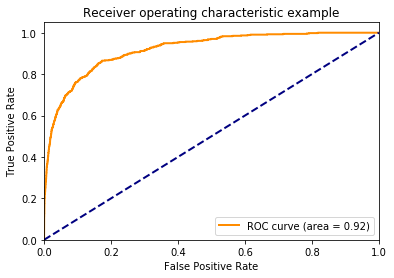

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


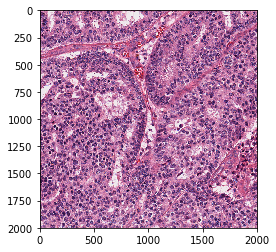

In [76]:
cases_test = [13,14,15,16,17,18,19,20,21,22,23] 
#Loading one image and doing dense prediction using a sliding window:
#ex_img = np.array(Image.open('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/01.tif'))
ex_img = load_image('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/15/25.tif', range_min=0, range_max=1)/255.
plt.imshow(ex_img*255)

In [30]:
#cur_thing_s = np.concatenate((cur_thing,cur_thing),axis=0)        
#cur_thing_ss = np.concatenate((cur_thing_s,cur_thing_s),axis=0)
#cur_thing_sss = np.concatenate((cur_thing_ss,cur_thing_ss),axis=0)
#cur_thing_ssss = np.concatenate((cur_thing_sss,cur_thing_sss),axis=0)
limit_gpu_array = np.random.rand(1937,63,63,3)
print(limit_gpu_array.shape)

(1937, 63, 63, 3)


In [39]:
start = time.time()

l = model_mitosis.predict_proba(limit_gpu_array,batch_size=limit_gpu_array.shape[0])

#print(str(cur_thing_ssss.shape[0]))
end = time.time()
print("Time elapsed on variable batch size inference :" + str(end - start))


Time elapsed on variable batch size inference :0.25733423233032227


In [77]:
start = time.time()
all_probs_old = compute_probs_sliding_window_v2(model_mitosis,ex_img)
end = time.time()
print("Time for computing all dense predictions of a single image: " + str(end - start))

1936 iterations - Time elapsed on gpu + comprehension :533.5287849903107
Time for computing all dense predictions of a single image: 533.5484127998352


In [ ]:
start = time.time()
all_probs = compute_probs_sliding_window_v1(model_mitosis,ex_img)
end = time.time()
print("Time for computing all dense predictions of a single image: " + str(end - start))

In [419]:
print(all_probs.shape)
print(np.array(all_probs_old).shape)

(1938, 1938, 2)
(1937, 1937, 2)


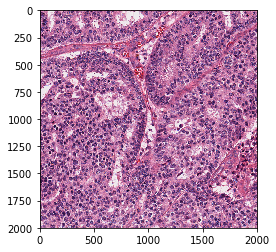

In [41]:
plt.imshow(ex_img)

55241


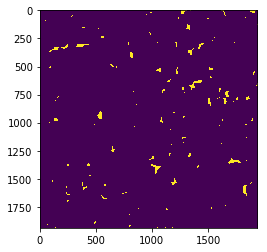

In [117]:
from skimage.morphology import dilation,square,erosion
pp = erosion(bin_mask_mf, selem=square(20), out=None, shift_x=False, shift_y=False)
all_pairs_pp = list(zip(np.nonzero(pp)[0],np.nonzero(pp)[1]))
print(len(all_pairs_pp))
plt.imshow(pp)

In [47]:
def compute_detectcions_performance(D,coords_patches,distance_gt_pxs):
    #D is asume to be a list with items: [(coord_x,coord_y), mf[(coord_x,coord_y)]]
    tp=0
    fp = 0
    fn = 0
    tp_locs = []
    for item in D:
        is_tp = False
        for coord_gt in coords_patches:
            dist_item = manhattan_distances([[item[0][0], item[0][1]]], [[coord_gt[0], coord_gt[1]]])[0][0] 
            if dist_item < distance_gt_pxs: #centroid closer than 30 pixels is cosidered GT 
                tp +=1
                tp_locs.append(item)
                is_tp = True
        if is_tp == False:
            fp +=1
    for coord_gt in coords_patches:
        is_fn = True
        for item in D:
            dist_item = manhattan_distances([[item[0][0], item[0][1]]], [[coord_gt[0], coord_gt[1]]])[0][0]
            if dist_item < distance_gt_pxs:
                is_fn = False
        if is_fn:
            fn +=1
    if tp+fn !=0 and tp+fp !=0:
        P = tp/(tp+fp)
        R = tp/(tp+fn)
        if (P+R) == 0:
            f1 = 0
            print("Addition of P and R equal 0!")
        else:
            f1 = 2*(P*R)/(P+R)
    else:
        return 0,0,0, tp, fp, fn
    return f1,P,R, tp, fp,fn

In [131]:
#distance_gt_pxs = 40
#D = [[(10, 29), 0.897356390953064], [(100, 100), 0.897356390953064], [(500,500), 0.897356390953064]]
#coords_patches = [[766,267],[58,1380],[568,1068],[1657,808]]
#print(D[0:3])

#print(coords_patches)
#f1,P,R, tp, fp,fn = compute_detectcions_performance(D,coords_patches,distance_gt_pxs)
#print(f1,P,R,tp, fp,fn)


In [132]:
def local_maxima_supression(all_probs,radius,best_val_thres):
    #radius = 32
    D = []
    mf = all_probs[:,:,1]
    bin_mask_mf = np.array(mf> best_val_thres,dtype=int)
    #bin_mask_mf_smothd = smooth_probability_map(bin_mask_mf, blob_size=20)
    bin_mask_mf = erosion(bin_mask_mf, selem=square(20), out=None, shift_x=False, shift_y=False)

    all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
    while(len(all_pairs_p)>0):
        #plt.imshow(bin_mask_mf)
        p_m = np.unravel_index(np.argmax(np.multiply(mf,bin_mask_mf)), mf.shape) 
        p_m_val = np.max(np.multiply(mf,bin_mask_mf))
        print(p_m,p_m_val,len(all_pairs_p))
        D.append((p_m,p_m_val))
        for item in all_pairs_p:
            if manhattan_distances([[item[0], item[1]]], [[p_m[0], p_m[1]]])[0][0] < 2*radius:
                bin_mask_mf[item[0],item[1]] = 0 #This makes all_pairs_p decrease in length 
        all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
    return D #The final detections

In [133]:
list_csv = glob.glob(config.PATH_GT + '**/*.csv')
print(len(list_csv))
dict_image_csv = {i:[] for i in list(1+np.arange(73))}
for item in list_csv:
    casenum = int(item.split('/')[-2])
    if casenum in dict_image_csv.keys():
        dict_image_csv[casenum].append(item)
    else:
        dict_image_csv[casenum] = []
print(dict_image_csv.keys())

587
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])


In [134]:
#Reading the GT coordinates for the current test case, any detection closer than 20 pixels  to a center will be
#considered as a true positive
stride_x,stride_y = 63,63
radius = 32
distance_gt_pxs = 22

all_meassures = []
for idx_case in cases_test:
    for csv_num in range(len(dict_image_csv[idx_case])):
        print("Computing performance for " +str(dict_image_csv[idx_case][csv_num]) )
        csv_path = dict_image_csv[idx_case][csv_num]
        coords_patches, patches, ex_img = localize_mitosis_patches(csv_path,return_img = True)
        #all_probs = compute_probs_sliding_window(model_mitosis,ex_img,stride_x,stride_y)
        all_probs = compute_probs_sliding_window_v2(model_mitosis,ex_img/255.)
        D = local_maxima_supression(all_probs,radius,best_val_thres)
        all_meassures.append(compute_detectcions_performance(D,coords_patches,distance_gt_pxs))
        print(coords_patches,  ex_img.shape)

Computing performance for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/13/06.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/06.tif
1936 iterations - Time elapsed on gpu + comprehension :538.7970163822174


ZeroDivisionError: division by zero

In [ ]:
#f1,P,R, tp, fp,fn 
tp = np.array(all_meassures)[:,3].sum()
fp = np.array(all_meassures)[:,4].sum()
fn = np.array(all_meassures)[:,5].sum()
print(tp,fp,fn)

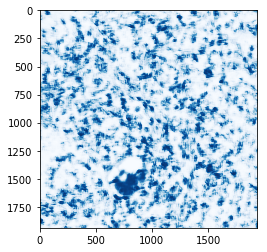

In [51]:
#mycmap = transparent_cmap(plt.cm.hot)
import scipy.misc

fig, ax = plt.subplots(1, 1)
ax.imshow(np.multiply(all_probs[:,:,0],255),cmap=plt.cm.Blues)
img_fname = 'Mf_img_' + str(2) + '.png'
out_file_path = '/home/sebastian/local_experiments/staining/results/tupac/images/'+img_fname
#scipy.misc.imsave(out_file_path, np.multiply(kk,255),cmap=plt.cm.Blues)
#fig.savefig('/home/sebastian/pp.png')

plt.imsave(
            out_file_path,
            np.multiply(all_probs[:,:,0],255),
            cmap=plt.cm.Blues,
            vmin=0,
            vmax=255)